In [1]:
%load_ext autoreload
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
import os
from collections import defaultdict 
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torchvision
import torchio as tio

from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison, video, get_capacity
from celluloid import Camera
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from utils import DiceScoreBinary, DiceLossBinary
from datasets import create_datasets

%autoreload 2

In [2]:
!nvidia-smi

Tue Apr  5 09:34:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 33%   77C    P2    99W / 250W |  10637MiB / 12211MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 42%   

In [4]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = 'cpu'
plt.rcParams['font.size'] = 20

In [7]:
DATASET = 'FCD' # 'BRATS' # 'FCD'

In [47]:
logdir = './logs_approach_comparison/v2v_whole_s128_bs1_GN_Dice-BCE250_lr1e-3_ALL-MNI152-AUG@04.04.2022-23:31:41'
# logdir = './logs_approach_comparison/v2v_whole_s128_bs1_GN_Dice_lr1e-3_ALL-MNI152-AUG@04.04.2022-23:12:47'

In [48]:
val_preds_path = os.path.join(logdir, 'best_val_preds')

In [49]:
os.listdir(val_preds_path)

['24', '38', 'n5', '48', '1', 'G324', 'n11', 'G414', 'n15', 'G258']

In [50]:
best_val_preds = {}
for label in os.listdir(val_preds_path):
    val_preds_label_path = os.path.join(val_preds_path, label)
    best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

In [51]:
best_val_preds['24'].shape

(128, 128, 128)

### Load model, setup dataloaders

In [52]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [53]:
config

{'make_logs': True,
 'interpolate': True,
 'interpolation_size': [128, 128, 128],
 'silent': False,
 'opt': {'device': 1,
  'criterion': 'DiceBCE',
  'bce_weights': 250,
  'start_epoch': 0,
  'n_epochs': 9999,
  'augmentation': True,
  'train_batch_size': 1,
  'val_batch_size': 1,
  'lr': 0.001,
  'save_model': True},
 'model': {'name': 'v2v',
  'output_channels': 1,
  'max_channel_encoder_decoder': 128,
  'sigmoid': True,
  'normalization': 'group_norm',
  'use_greedy_saving': False,
  'target_metric_name': 'dice_score'},
 'dataset': {'save_best_val_predictions': True,
  'trim_background': True,
  'features': ['curv',
   'sulc',
   'thickness',
   'bT1',
   'bT2',
   'T1w',
   'CSF',
   'GM',
   'WM',
   'cr',
   'entropy'],
  'root': '/nfs/tom/ibulygin/fcd_data/tensors_MNI152',
  'metadata_path': 'metadata/metadata_fcd.npy',
  'dataset_type': 'interpolated'}}

In [54]:

# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
assert config.opt.train_batch_size == 1

###################
# CREATE DATASETS #
###################
train_dataset, val_dataset = create_datasets(config)
collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=False,
                                collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)
print(len(train_dataloader), len(val_dataloader))

print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))

121 10
val dataloder len:  10 train dataloder len:  121


In [55]:
len(val_dataloader)

10

# Forward pass

In [56]:
brains = {}
labels_gt = {}
metric_dict = defaultdict(dict)

iterator = enumerate(val_dataloader)
labels = val_dataloader.dataset.labels

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):
        
        if config.interpolate:
            brain_tensor = F.interpolate(brain_tensor, config.interpolation_size)
            label_tensor = F.interpolate(label_tensor, config.interpolation_size)
            mask_tensor = F.interpolate(mask_tensor, config.interpolation_size)
        
        label = labels[iter_i]
        label_tensor_predicted = torch.tensor(best_val_preds[label][None,None,...])
        
        dice_score = DiceScoreBinary(label_tensor_predicted, label_tensor)
        coverage = (label_tensor_predicted*label_tensor).sum() / label_tensor.sum()
            
        metric_dict['coverage'][label] = coverage.item()
        metric_dict['dice_score'][label] = dice_score.item()
        brains[label] = brain_tensor[0].numpy()
        labels_gt[label] = label_tensor[0,0].numpy()
        


10it [02:36, 15.62s/it]


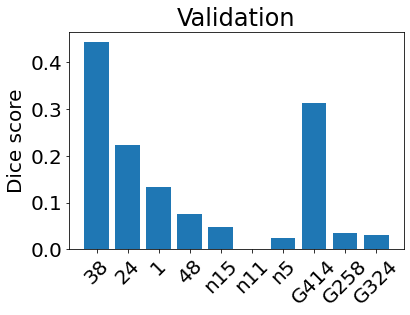

In [57]:
plt.ion()
plt.figure()
plt.bar(metric_dict['dice_score'].keys(), metric_dict['dice_score'].values())
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

### hard examples

DiceBCE - [n11, n5, n15, 48, G258, G324]  
DICE - [38, 1, 48, n11]

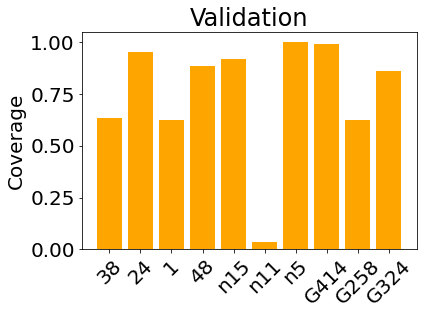

In [58]:
plt.ion()
plt.figure()
plt.bar(metric_dict['coverage'].keys(), metric_dict['coverage'].values(), color='orange')
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Coverage')
plt.xticks(rotation=45)
plt.show()

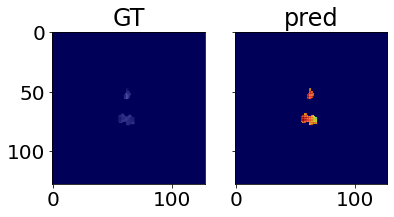

In [60]:
label = 'n11'

plt.ioff()
camera = video_comparison([brains[label][0], brains[label][0]], 
                          [labels_gt[label], best_val_preds[label]], 
                          titles=['GT', 'pred'],
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
tio.